Original Data source
https://nihcc.app.box.com/v/ChestXray-NIHCC

Google Healthcare APIs
https://cloud.google.com/healthcare-api/docs/resources/public-datasets/nih-chest





In [3]:
!apt-get update && apt-get install -y libgl1

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease                       
Hit:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease               
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Fetched 129 kB in 1s (121 kB/s)                        
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgl1 is already the newest version (1.4.0-1).
0 upgraded, 0 newly installed, 0 to remove and 104 not upgraded.


In [4]:
!pip install kagglehub
!pip install kagglehub[pandas-datasets]
!pip install wget
!pip install keras-tuner
!pip install seaborn
!pip install opencv-python
!pip install scikit-learn
!pip install fastparquet


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


### Load Libraries

In [5]:
import os
import json
import zipfile
import seaborn as sns
import numpy as np
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import urllib.request

import tensorflow as tf
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import layers, models, Input, Model, Sequential
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch
from tensorflow.keras.regularizers import l2  # <-- MISSING IMPORT

2025-04-13 13:56:50.456786: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/tmp/ipykernel_3299336/3446843813.py:20: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel


In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

In [7]:
!cd /workspace/chest
!mkdir -p /workspace/chest/drive/MyDrive/AAI-590_Collabs

In [8]:
# Global flags
SKIP_BOUNDING_BOX = True
SKIP_DOWNLOAD = False
SKIP_UNZIP = False

ROOT_PATH = "/workspace/chest"
# ROOT_PATH = "/content"

DRIVE_PATH = ROOT_PATH + "/drive/MyDrive/AAI-590_Collabs"
RESIZED_IMAGES_ZIP_PATH = ROOT_PATH + "/drive/MyDrive/AAI-590_Collabs"
RESIZED_IMAGES_ZIP_PATH = ROOT_PATH
RESIZED_IMAGES_PATH = ROOT_PATH + "/images_resized/images_resized";

In [9]:
SKIP_DOWNLOAD = os.path.exists(RESIZED_IMAGES_ZIP_PATH)
SKIP_UNZIP = os.path.exists(RESIZED_IMAGES_PATH)

In [10]:
# print current variables
print("SKIP_DOWNLOAD: ", SKIP_DOWNLOAD)
print("SKIP_UNZIP: ", SKIP_UNZIP)

SKIP_DOWNLOAD:  True
SKIP_UNZIP:  True


### Load Dataset

In [11]:
# Set the dataset path
dataset_name = "nih-chest-xrays/data"
version = 3
# Set the path to the file you'd like to load
file_path = "Data_Entry_2017.csv"
file_path_bbox = "BBox_List_2017.csv"

gcloud_url_base = 'https://storage.googleapis.com/gcs-public-data--healthcare-nih-chest-xray/png/'

In [12]:
# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  dataset_name,
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

df_box_list = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  dataset_name,
  file_path_bbox
)

/tmp/ipykernel_3299336/2090411782.py:2: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df = kagglehub.load_dataset(
/tmp/ipykernel_3299336/2090411782.py:12: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df_box_list = kagglehub.load_dataset(


In [13]:
print(df['View Position'].value_counts())

View Position
PA    67310
AP    44810
Name: count, dtype: int64


In [14]:
# keep orignal dataframe for reference
df_locked = df.copy()

In [15]:
links = [
    "https://nihcc.box.com/shared/static/vfk49d74nhbxq3nqjg0900w5nvkorp5c.gz",
    "https://nihcc.box.com/shared/static/i28rlmbvmfjbl8p2n3ril0pptcmcu9d1.gz",
    "https://nihcc.box.com/shared/static/f1t00wrtdk94satdfb9olcolqx20z2jp.gz",
    "https://nihcc.box.com/shared/static/0aowwzs5lhjrceb3qp67ahp0rd1l1etg.gz",
    "https://nihcc.box.com/shared/static/v5e3goj22zr6h8tzualxfsqlqaygfbsn.gz",
    "https://nihcc.box.com/shared/static/asi7ikud9jwnkrnkj99jnpfkjdes7l6l.gz",
    "https://nihcc.box.com/shared/static/jn1b4mw4n6lnh74ovmcjb8y48h8xj07n.gz",
    "https://nihcc.box.com/shared/static/tvpxmn7qyrgl0w8wfh9kqfjskv6nmm1j.gz",
    "https://nihcc.box.com/shared/static/upyy3ml7qdumlgk2rfcvlb9k6gvqq2pj.gz",
    "https://nihcc.box.com/shared/static/l6nilvfa9cg3s28tqv1qc1olm3gnz54p.gz",
    "https://nihcc.box.com/shared/static/hhq8fkdgvcari67vfhs7ppg2w6ni4jze.gz",
    "https://nihcc.box.com/shared/static/ioqwiy20ihqwyr8pf4c24eazhh281pbu.gz",
]

In [16]:
# Create a dictionary for folder locations
folder_ranges = {
    "images_001": (0, 4998),  # Adjusted to 0-based index
    "images_002": (4999, 14998),
    "images_003": (14999, 24998),
    "images_004": (24999, 34998),
    "images_005": (34999, 44998),
    "images_006": (44999, 54998),
    "images_007": (54999, 64998),
    "images_008": (64999, 74998),
    "images_009": (74999, 84998),
    "images_010": (84999, 94998),
    "images_011": (94999, 104998),
    "images_012": (104999, 112120)
}

def get_image_folder(df, image_name):
    if image_name in df["Image Index"].values:
        image_index = df[df["Image Index"] == image_name].index[0]  # Get row index
        # print(f"Image {image_name} is at index {image_index}")  # Debugging output

        for folder, (start, end) in folder_ranges.items():
            if start <= image_index <= end:
                return folder

    return None  # If not found

## Data Cleaning

## Remove all where "View Position" column value is "AP"
AP means "anteroposterior dimension" which is an X-ray from front-to-back
This wil affect the training with both back-to-front and front-to-back images of MRIs

In [17]:
# Entries before removal
print(f"Before 'AP' removal: {df['View Position'].value_counts()}")

# Entries after removal
df = df[df['View Position'] != 'AP']

# Remaining data is 66.57% of total initial data
print(f"After 'AP' removal: {df['View Position'].value_counts()}")

Before 'AP' removal: View Position
PA    67310
AP    44810
Name: count, dtype: int64
After 'AP' removal: View Position
PA    67310
Name: count, dtype: int64


In [18]:
display(df.head())
display(df.tail())
display(df.columns)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,0.168,NaN
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,0.168,NaN
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168,NaN
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,0.168,NaN
112119,00030805_000.png,No Finding,0,30805,27,M,PA,2048,2500,0.171,0.171,NaN


Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11'],
      dtype='object')

### We want to have 7 generalized classes from the original 15

Take values from "Finding Labels" and convert them into more generalized labels

In [19]:
# Create a list to store all unique labels
all_labels = []

# Iterate over the 'Finding Labels' column
for index, row in df.iterrows():
    labels = row['Finding Labels'].split('|')
    for label in labels:
        all_labels.append(label)

# Get unique labels and print them
all_labels = list(set(all_labels))
print(f"All possible options in 'Finding Labels': {all_labels}")

All possible options in 'Finding Labels': ['Effusion', 'Atelectasis', 'Edema', 'Hernia', 'Pleural_Thickening', 'Nodule', 'Pneumonia', 'Cardiomegaly', 'No Finding', 'Pneumothorax', 'Infiltration', 'Emphysema', 'Fibrosis', 'Mass', 'Consolidation']


In [20]:
category_map = {
    'Infection/Infiltration': ['has_Pneumonia', 'has_Consolidation', 'has_Infiltration'],
    'Fluid Related Issues': ['has_Edema', 'has_Effusion', 'has_Pleural_Thickening'],
    'Lung Structure Issues': ['has_Atelectasis', 'has_Pneumothorax', 'has_Fibrosis', 'has_Emphysema'],
    'Nodule/Mass': ['has_Nodule', 'has_Mass'],
    'Cardiac Issues': ['has_Cardiomegaly'],
    'Hernia': ['has_Hernia'],
    'No Finding': ['has_No Finding']
}

def generalize_labels(label):
    if label in ['Pneumonia', 'Consolidation', 'Infiltration']:
        return 'Infection/Infiltration'
    elif label in ['Edema', 'Effusion', 'Pleural_Thickening']:
        return 'Fluid Related Issues'
    elif label in ['Atelectasis', 'Pneumothorax', 'Fibrosis', 'Emphysema']:
        return 'Lung Structure Issues'
    elif label in ['Nodule', 'Mass']:
        return 'Nodule/Mass'
    elif label == 'Cardiomegaly':
        return 'Cardiac Issues'
    elif label == 'Hernia':
        return 'Hernia'
    else:
        return label  # If we don't detect an issue 'No Finding'


categories = category_map.keys()
df['Finding Labels'] = df['Finding Labels'].apply(lambda x: '|'.join([generalize_labels(label) for label in x.split('|')]))

# Example:
display(df.head()) # View the updated DataFrame

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiac Issues,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiac Issues|Lung Structure Issues,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiac Issues|Fluid Related Issues,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [21]:
display(df.head())
display(df.tail())
display(df.columns)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiac Issues,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiac Issues|Lung Structure Issues,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiac Issues|Fluid Related Issues,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
112115,00030801_001.png,Nodule/Mass|Infection/Infiltration,1,30801,39,M,PA,2048,2500,0.168,0.168,NaN
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,0.168,NaN
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168,NaN
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,0.168,NaN
112119,00030805_000.png,No Finding,0,30805,27,M,PA,2048,2500,0.171,0.171,NaN


Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11'],
      dtype='object')

In [22]:
display(df.describe())
display(df.info())

,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
count,67310.000000,67310.000000,67310.000000,67310.000000,67310.000000,67310.000000,67310.000000,0.0
mean,4.786317,14396.542802,47.352979,2632.590016,2652.208468,0.153868,0.153868,NaN
std,9.403191,8559.885944,16.289550,374.573816,396.607849,0.017179,0.017179,NaN
min,0.000000,1.000000,1.000000,1143.000000,1001.000000,0.115000,0.115000,NaN
25%,0.000000,7157.250000,36.000000,2500.000000,2411.000000,0.143000,0.143000,NaN
50%,1.000000,14112.000000,49.000000,2678.000000,2885.000000,0.143000,0.143000,NaN
75%,5.000000,21117.750000,59.000000,2992.000000,2991.000000,0.168000,0.168000,NaN
max,156.000000,30805.000000,412.000000,3056.000000,3056.000000,0.194336,0.194336,NaN


<class 'pandas.core.frame.DataFrame'>
Index: 67310 entries, 0 to 112119
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Image Index                  67310 non-null  object 
 1   Finding Labels               67310 non-null  object 
 2   Follow-up #                  67310 non-null  int64  
 3   Patient ID                   67310 non-null  int64  
 4   Patient Age                  67310 non-null  int64  
 5   Patient Gender               67310 non-null  object 
 6   View Position                67310 non-null  object 
 7   OriginalImage[Width          67310 non-null  int64  
 8   Height]                      67310 non-null  int64  
 9   OriginalImagePixelSpacing[x  67310 non-null  float64
 10  y]                           67310 non-null  float64
 11  Unnamed: 11                  0 non-null      float64
dtypes: float64(3), int64(5), object(4)
memory usage: 6.7+ MB


None

## Pre-processing

---



In [23]:
# Reduce rows with 'No Finding' label to a maximum of 10,000
no_finding_df = df[df['Finding Labels'] == 'No Finding']
if len(no_finding_df) > 10000:
    no_finding_df = no_finding_df.sample(n=10000, random_state=42)  # Randomly sample 10,000 rows

# Concatenate the reduced 'No Finding' rows with other rows
other_findings_df = df[df['Finding Labels'] != 'No Finding']
df = pd.concat([no_finding_df, other_findings_df], ignore_index=True)

display(len(df))

38008

In [24]:
# Rename columns
df = df.rename(columns={
    "OriginalImage[Width": "width",
    "Height]": "height",
    "OriginalImagePixelSpacing[x": "pixel_spacing x",
    "y]": "pixel_spacing y"
})

display(df.head())

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,width,height,pixel_spacing x,pixel_spacing y,Unnamed: 11
0,00019856_000.png,No Finding,0,19856,57,M,PA,2992,2991,0.143,0.143,NaN
1,00001020_000.png,No Finding,0,1020,52,M,PA,2500,2048,0.171,0.171,NaN
2,00008187_001.png,No Finding,1,8187,59,M,PA,2500,2048,0.168,0.168,NaN
3,00003360_003.png,No Finding,3,3360,8,M,PA,2048,2500,0.168,0.168,NaN
4,00014364_000.png,No Finding,0,14364,26,F,PA,2454,2991,0.143,0.143,NaN


In [25]:
# drop columns that will not be used for traning, except Patient ID that will be used for patient-level split
df = df.drop(columns=['Unnamed: 11', 'width', 'height', 'View Position', 'pixel_spacing x', 'pixel_spacing y'], errors='ignore')

In [26]:
# Extract all unique labels
all_labels = sorted(set(label for sublist in df['Finding Labels'].str.split('|') for label in sublist))
display(all_labels)

# Encode multi-labels
def encode_multilabel(labels):
    label_set = labels.split('|')
    return [1 if label in label_set else 0 for label in all_labels]

df['encoded_labels'] = df['Finding Labels'].apply(encode_multilabel)
display(df.head())

y = np.array(df['encoded_labels'].tolist())

['Cardiac Issues',
 'Fluid Related Issues',
 'Hernia',
 'Infection/Infiltration',
 'Lung Structure Issues',
 'No Finding',
 'Nodule/Mass']

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,encoded_labels
0,00019856_000.png,No Finding,0,19856,57,M,"[0, 0, 0, 0, 0, 1, 0]"
1,00001020_000.png,No Finding,0,1020,52,M,"[0, 0, 0, 0, 0, 1, 0]"
2,00008187_001.png,No Finding,1,8187,59,M,"[0, 0, 0, 0, 0, 1, 0]"
3,00003360_003.png,No Finding,3,3360,8,M,"[0, 0, 0, 0, 0, 1, 0]"
4,00014364_000.png,No Finding,0,14364,26,F,"[0, 0, 0, 0, 0, 1, 0]"


In [85]:
print(all_labels)

['Cardiac Issues', 'Fluid Related Issues', 'Hernia', 'Infection/Infiltration', 'Lung Structure Issues', 'No Finding', 'Nodule/Mass']


#### Encode Tabular Labels

In [27]:
# Extract each label to a separate boolean column
for label in categories:
  df[f'has_{label}'] = df['Finding Labels'].str.contains(label)
  # encode to 0 and 1
  df[f'has_{label}'] = df[f'has_{label}'].astype(int)

df = df.drop(columns=['Finding Labels'], errors='ignore')
display(df.head())

,Image Index,Follow-up #,Patient ID,Patient Age,Patient Gender,encoded_labels,has_Infection/Infiltration,has_Fluid Related Issues,has_Lung Structure Issues,has_Nodule/Mass,has_Cardiac Issues,has_Hernia,has_No Finding
0,00019856_000.png,0,19856,57,M,"[0, 0, 0, 0, 0, 1, 0]",0,0,0,0,0,0,1
1,00001020_000.png,0,1020,52,M,"[0, 0, 0, 0, 0, 1, 0]",0,0,0,0,0,0,1
2,00008187_001.png,1,8187,59,M,"[0, 0, 0, 0, 0, 1, 0]",0,0,0,0,0,0,1
3,00003360_003.png,3,3360,8,M,"[0, 0, 0, 0, 0, 1, 0]",0,0,0,0,0,0,1
4,00014364_000.png,0,14364,26,F,"[0, 0, 0, 0, 0, 1, 0]",0,0,0,0,0,0,1


In [28]:
# Encode gender (e.g., Male/Female -> 0/1)
df['Patient Gender'] = LabelEncoder().fit_transform(df['Patient Gender'])

# Standardize numerical features
scaler = StandardScaler()
df['Patient Age'] = scaler.fit_transform(df[['Patient Age']])
df['Follow-up #'] = scaler.fit_transform(df[['Follow-up #']])

display(df.head())

,Image Index,Follow-up #,Patient ID,Patient Age,Patient Gender,encoded_labels,has_Infection/Infiltration,has_Fluid Related Issues,has_Lung Structure Issues,has_Nodule/Mass,has_Cardiac Issues,has_Hernia,has_No Finding
0,00019856_000.png,-0.552742,19856,0.525833,1,"[0, 0, 0, 0, 0, 1, 0]",0,0,0,0,0,0,1
1,00001020_000.png,-0.552742,1020,0.215450,1,"[0, 0, 0, 0, 0, 1, 0]",0,0,0,0,0,0,1
2,00008187_001.png,-0.457542,8187,0.649986,1,"[0, 0, 0, 0, 0, 1, 0]",0,0,0,0,0,0,1
3,00003360_003.png,-0.267142,3360,-2.515918,1,"[0, 0, 0, 0, 0, 1, 0]",0,0,0,0,0,0,1
4,00014364_000.png,-0.552742,14364,-1.398540,0,"[0, 0, 0, 0, 0, 1, 0]",0,0,0,0,0,0,1


### Retrieive Images

In [29]:
import os
import tarfile
import urllib.request

def download_and_extract(links, folder_ranges, df_locked):
    """Downloads image archives, extracts them, and organizes images."""

    if not os.path.exists("images"):
        os.makedirs("images")

    for i, link in enumerate(links):
        folder_name = f"images_{i+1:03d}"
        archive_name = f"{folder_name}.tar.gz"

        if not os.path.exists(os.path.join("images", archive_name)): #check if the archive already exists to prevent unnecessary downloads
          print(f"Downloading {archive_name}...")
          urllib.request.urlretrieve(link, archive_name)
        else:
          print(f"Skipping download for {archive_name} as file already exists")


        try:
            print(f"Extracting {archive_name}...")
            with tarfile.open(archive_name, "r:gz") as tar:
                tar.extractall()
            print("Extraction complete.")
        except Exception as e:
            print(f"Error extracting {archive_name}: {e}")
            continue  # Skip to the next archive if extraction fails

        # Move extracted images to the 'images' folder
        source_folder = folder_name
        if os.path.exists(source_folder):
          extracted_files = os.listdir(source_folder)
          for file in extracted_files:
            source_file = os.path.join(source_folder, file)
            destination_file = os.path.join("images", file)
            try:
              os.rename(source_file, destination_file)
            except FileExistsError:
              print(f"File {file} already exists in images folder, skipping")

          os.rmdir(source_folder)
        else:
          print(f"Folder {source_folder} doesn't exist")


        # Remove the archive file
        try:
            os.remove(archive_name)
            print(f"Removed {archive_name}")
        except OSError as e:
            print(f"Error removing {archive_name}: {e}")

if SKIP_DOWNLOAD == False:
  download_and_extract(links, folder_ranges, df_locked)

In [30]:
if SKIP_DOWNLOAD == False:
  image_folder = 'images'
  num_images = len([f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))])
  print(f"Number of images in '{image_folder}' folder: {num_images}")

In [31]:
if SKIP_DOWNLOAD == False:
  image_folder = 'images'

  # Get a set of image names from the 'Image Index' column of the DataFrame
  image_names_in_df = set(df['Image Index'].unique())

  print(len(image_names_in_df))

  # Iterate through all files in the image folder
  for filename in os.listdir(image_folder):
      filepath = os.path.join(image_folder, filename)

      # Check if it's a file and not in the DataFrame's 'Image Index' column
      if os.path.isfile(filepath) and filename not in image_names_in_df:
          try:
              os.remove(filepath)
              print(f"Removed file: {filename}")
          except OSError as e:
              print(f"Error deleting file {filename}: {e}")


In [32]:
image_folder = 'images'
def get_num_images(image_folder):
  num_images = len([f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))])
  return num_images

if SKIP_DOWNLOAD == False:
  print(f"Number of images in '{image_folder}' folder: {get_num_images(image_folder)}")

In [33]:
if SKIP_DOWNLOAD == False:
  !python image_scale.py

In [34]:
if SKIP_DOWNLOAD == False:
  !zip -r images_resized.zip images_resized

In [35]:
if SKIP_DOWNLOAD == False:
  print(f"Number of images in 'images_resized' folder: {get_num_images('images_resized')}")

In [36]:
def zip_folder(folder_path, zip_filename):
  """Zips a folder.
  Args:
    folder_path: The path to the folder to zip.
    zip_filename: The name of the zip file to create.
  """

  # Create a zip archive
  with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, _, files in os.walk(folder_path):
      for file in files:
        zipf.write(os.path.join(root, file),
                   os.path.relpath(os.path.join(root, file),
                                   os.path.join(folder_path, '..')))
if SKIP_DOWNLOAD == False:
  zip_folder('images_resized', 'images_resized.zip')

In [37]:
if SKIP_DOWNLOAD == False:
  !cp images_resized.zip {RESIZED_IMAGES_ZIP_PATH}

In [38]:
import zipfile
import os

def unzip_files(zip_path, extract_path):
    """Unzips files from a zip archive to a specified directory.

    Args:
        zip_path: Path to the zip file.
        extract_path: Directory to extract the files to.
    """
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print(f"Successfully unzipped '{zip_path}' to '{extract_path}'")
    except FileNotFoundError:
        print(f"Error: Zip file not found at '{zip_path}'")
    except zipfile.BadZipFile:
        print(f"Error: Invalid zip file at '{zip_path}'")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# Assuming RESIZED_IMAGES_ZIP_PATH is defined and holds the correct path
if SKIP_UNZIP == False:
  unzip_files(RESIZED_IMAGES_ZIP_PATH + "/images_resized.zip", "images_resized")


In [39]:
import glob
import random
from PIL import Image

def show_image_tiles(
        folder: str,
        pattern: str = "*.png",          # glob pattern: "*.jpg", "*.jpeg", etc.
        max_images: int | None = None,   # cap the number shown; None = all
        cols: int = 10,                  # how many tiles per row
        thumb_size: tuple[int, int] = (128, 128),  # resize for speed
        shuffle: bool = True,            # randomise order
        seed: int | None = 42            # reproducible shuffle
    ):
    """
    Display images from *folder* as a tiled grid.

    Parameters
    ----------
    folder : str
        Path to the directory containing images.
    pattern : str, default "*.png"
        Glob pattern to match files.
    max_images : int or None, default None
        Show at most this many images.
    cols : int, default 10
        Number of tiles per row.
    thumb_size : (int, int), default (128, 128)
        Target size for thumbnails (width, height).
    shuffle : bool, default True
        Shuffle file list before displaying.
    seed : int or None, default 42
        Seed for reproducible shuffling.
    """
    # --------------------------------------------------------------------- #
    # 1. Gather files
    # --------------------------------------------------------------------- #
    paths = glob.glob(os.path.join(folder, pattern))
    if not paths:
        raise FileNotFoundError(f"No files matching {pattern} in {folder}")

    if shuffle:
        rng = random.Random(seed)
        rng.shuffle(paths)

    if max_images:
        paths = paths[:max_images]

    n_imgs = len(paths)
    rows   = math.ceil(n_imgs / cols)

    # --------------------------------------------------------------------- #
    # 2. Create the figure
    # --------------------------------------------------------------------- #
    # scale figsize so that each thumbnail has ~thumb_size/64 inches
    w_inch = cols * thumb_size[0] / 64
    h_inch = rows * thumb_size[1] / 64
    fig, axes = plt.subplots(rows, cols,
                             figsize=(w_inch, h_inch),
                             squeeze=False)
    axes = axes.ravel()

    # --------------------------------------------------------------------- #
    # 3. Plot each image
    # --------------------------------------------------------------------- #
    for ax, path in zip(axes, paths):
        img = Image.open(path)
        img.thumbnail(thumb_size, Image.Resampling.LANCZOS)
        ax.imshow(img, cmap="gray" if img.mode == "L" else None)
        ax.set_title(os.path.basename(path), fontsize=6)
        ax.axis("off")

    # Hide any leftover axes
    for ax in axes[n_imgs:]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# show_image_tiles(
#     folder="images_resized/images_resized",
#     pattern="*.png",
#     max_images=500,        # None = show everything
#     cols=12,               # 12 images per row
#     thumb_size=(96, 96)    # smaller thumbnails → faster
# )

 ### Train / Tests Split

In [40]:
# Perform train/validation split
def patient_level_split(df, test_val_size=0.2, test_size=0.5, random_state=42):
    patient_ids = df['Patient ID'].unique()

    train_ids, holdout_ids = train_test_split(
        patient_ids,
        test_size=test_val_size,          # 20 % of patients will go to val+test
        random_state=random_state,
        shuffle=True
    )

    if test_size < 1.0:
        val_ids, test_ids = train_test_split(
            holdout_ids,
            test_size=test_size,          # half of the hold‑out → test, half → val
            random_state=random_state,
            shuffle=True
        )
    else:
        val_ids  = []
        test_ids = holdout_ids

    train_df = df[df['Patient ID'].isin(train_ids)].reset_index(drop=True)
    val_df   = df[df['Patient ID'].isin(val_ids)].reset_index(drop=True)
    test_df  = df[df['Patient ID'].isin(test_ids)].reset_index(drop=True)

    train_df = train_df.drop(columns=['Patient ID'], errors='ignore')
    val_df   = val_df.drop(columns=['Patient ID'], errors='ignore')
    test_df  = test_df.drop(columns=['Patient ID'], errors='ignore')

    return train_df, val_df, test_df

    
train_df, val_df, test_df = patient_level_split(df, test_val_size=0.2, test_size=1.0, random_state=42)
print("Train size:", len(train_df))
print("Val size:", len(val_df))
print("Test size:", len(test_df))

display(train_df.head())

Train size: 30499
Val size: 0
Test size: 7509


,Image Index,Follow-up #,Patient Age,Patient Gender,encoded_labels,has_Infection/Infiltration,has_Fluid Related Issues,has_Lung Structure Issues,has_Nodule/Mass,has_Cardiac Issues,has_Hernia,has_No Finding
0,00019856_000.png,-0.552742,0.525833,1,"[0, 0, 0, 0, 0, 1, 0]",0,0,0,0,0,0,1
1,00001020_000.png,-0.552742,0.215450,1,"[0, 0, 0, 0, 0, 1, 0]",0,0,0,0,0,0,1
2,00008187_001.png,-0.457542,0.649986,1,"[0, 0, 0, 0, 0, 1, 0]",0,0,0,0,0,0,1
3,00014364_000.png,-0.552742,-1.398540,0,"[0, 0, 0, 0, 0, 1, 0]",0,0,0,0,0,0,1
4,00003706_000.png,-0.552742,-0.032856,0,"[0, 0, 0, 0, 0, 1, 0]",0,0,0,0,0,0,1


### Class Imablance Addressing

In [41]:
class_columns = [col for col in df.columns if col.startswith("has_")]
# Calculate class distribution for the test dataset (val_df in this case)
class_distribution = train_df[class_columns].sum()
print(class_columns)

# Print the class distribution
print("Class Distribution in the Test Dataset:")
class_distribution


['has_Infection/Infiltration', 'has_Fluid Related Issues', 'has_Lung Structure Issues', 'has_Nodule/Mass', 'has_Cardiac Issues', 'has_Hernia', 'has_No Finding']
Class Distribution in the Test Dataset:


has_Infection/Infiltration    8789
has_Fluid Related Issues      6927
has_Lung Structure Issues     8668
has_Nodule/Mass               5711
has_Cardiac Issues            1246
has_Hernia                     154
has_No Finding                7994
dtype: int64

In [42]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Get class columns (already defined)
class_columns = [col for col in df.columns if col.startswith("has_")]

# Dictionary to hold weights for each task
task_class_weights = {}

# Loop through each task
for task in class_columns:
    y_task = train_df[task].values  # binary labels: 0 or 1
    weights = compute_class_weight(
        class_weight='balanced',
        classes=np.array([0, 1]),
        y=y_task
    )
    task_class_weights[task] = {
        0: weights[0],   # weight for class 0
        1: weights[1]    # weight for class 1
    }

# Display results
for task, weights in task_class_weights.items():
    print(f"{task}: 0 → {weights[0]:.2f}, 1 → {weights[1]:.2f}")

# Get only class-1 (positive) weights in order of class_columns
task_weights = [task_class_weights[task][1] for task in class_columns]
print("Task Weights (for loss):", task_weights)


has_Infection/Infiltration: 0 → 0.70, 1 → 1.74
has_Fluid Related Issues: 0 → 0.65, 1 → 2.20
has_Lung Structure Issues: 0 → 0.70, 1 → 1.76
has_Nodule/Mass: 0 → 0.62, 1 → 2.67
has_Cardiac Issues: 0 → 0.52, 1 → 12.24
has_Hernia: 0 → 0.50, 1 → 99.02
has_No Finding: 0 → 0.68, 1 → 1.91
Task Weights (for loss): [1.7350665604733189, 2.2014580626533853, 1.75928703276419, 2.670197863771669, 12.23876404494382, 99.02272727272727, 1.907618213660245]


In [43]:
IMG_SIZE = 512
IMG_SIZE = 480 # for EfficientNetV2L
# IMG_SIZE = 1024
# import tensorflow_addons.image as tfa_image

def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    # image = tf.cast(image, tf.float32) / 255.0 # EfficientNetV2 models expect their inputs to be float tensors of pixels with values in the [0, 255]
    contrast_factor = 2.5
    image = tf.image.adjust_contrast(image, contrast_factor)
    
    return image

def augment(image):
    # return image
    """Data augmentation function for single-channel images."""
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    
    # Random Rotation (within a reasonable range for chest X-rays)
    factor = tf.random.uniform(shape=[], minval=-0.1, maxval=0.1) # Rotates by +/- 0.1 * 2*pi radians
    # image = tf.image.rotate(image, factor) # error, doesn't exist
    # image = tfa_image.rotate(image, factor) # error, obsolete
    
    return image

In [44]:
# ~ 128MB per batch (1GB=4 batch size)
BATCH_SIZE = 8
# BATCH_SIZE = 16 # RTX 4090 24GB 32 for cnn_v0
# BATCH_SIZE = 128 # 32 # H100 80GB 128 fits, 168 too much for cnn_v0 with IMG_SIZE = 1024
# BATCH_SIZE = 64 # 32 # H100 80GB 64 fits, 96 too much for cnn_v1 with IMG_SIZE = 1024
def create_tf_datasets(task_df, is_training=True):
    print(f"Creating {'training' if is_training else 'validation'} datasets")

    image_paths = [os.path.join(RESIZED_IMAGES_PATH , image_name) for image_name in task_df['Image Index']]
    tabular_data = task_df[['Follow-up #', 'Patient Age', 'Patient Gender']].values
    target = np.stack(task_df['encoded_labels'].values).astype('float32')
    image_indices = task_df['Image Index'].astype(str).values       # keep as strings
    image_indices = tf.zeros(
        shape=len(task_df['Image Index'].values),
        dtype=tf.float32  # or tf.float32 if needed
    )

    # Create tf.data.Dataset from image paths, tabular data, and targets
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, tabular_data, target, image_indices))

    # Load and preprocess images using the provided preprocess_image function
    def _load_and_preprocess(path, tab, label, idx):
        img = preprocess_image(path)          # your existing helper
        return img, tab, label, idx

    dataset = dataset.map(_load_and_preprocess,
                          num_parallel_calls=tf.data.AUTOTUNE)

    # Pack into the model‑ready (inputs, label) tuple
    def _to_model_inputs(img, tab, label, idx):
        inputs = {
            "image_input":  img,
            "tabular_input": tab,
            "input_debug":   idx,    # <-- pass Image Index through
        }
        return inputs, label

    dataset = dataset.map(_to_model_inputs,
                          num_parallel_calls=tf.data.AUTOTUNE)

    # Augment (training only)  – keep input_debug untouched
    if is_training:
        dataset = dataset.shuffle(buffer_size=len(image_paths),
                                  reshuffle_each_iteration=True)

        def _augment(inputs, label):
            inputs = {
                "image_input":  augment(inputs["image_input"]),
                "tabular_input": inputs["tabular_input"],
                "input_debug":   inputs["input_debug"],   # keep as‑is
            }
            return inputs, label

        dataset = dataset.map(_augment,
                              num_parallel_calls=tf.data.AUTOTUNE)

    # Batch the dataset
    dataset = dataset.batch(BATCH_SIZE)
    # Prefetch for performance
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

def create_training_datasets(task_df):
    """Creates tf.data.Dataset for training and validation."""
    train_df, val_test_df = train_test_split(task_df, test_size=0.2, random_state=42)
    val_df, test_df = train_test_split(val_test_df, test_size=0.5, random_state=42)

    train_dataset = create_tf_datasets(train_df, is_training=True)
    val_dataset = create_tf_datasets(val_df, is_training=False)
    test_dataset = create_tf_datasets(test_df, is_training=False)

    return train_dataset, val_dataset, test_dataset

In [45]:
train_ds, val_ds, test_ds = create_training_datasets(train_df)

Creating training datasets


2025-04-13 13:56:56.660187: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22181 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:a1:00.0, compute capability: 8.9


Creating validation datasets
Creating validation datasets


In [46]:
for batch in train_ds.take(1):
    inputs, labels = batch
    print("Image input shape:", inputs["image_input"].shape)
    print("Tabular input shape:", inputs["tabular_input"].shape)
    print("Labels shape:", labels.shape)

2025-04-13 13:57:07.687766: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 6294 of 24399
2025-04-13 13:57:17.691232: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 12617 of 24399
2025-04-13 13:57:27.696847: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 17956 of 24399
2025-04-13 13:57:37.699463: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 23383 of 24399
2025-04-13 13:57:39.321472: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


Image input shape: (8, 480, 480, 1)
Tabular input shape: (8, 3)
Labels shape: (8, 7)


2025-04-13 13:57:39.595176: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Model Design/Building

In [47]:
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy('mixed_float16')

In [48]:
import tensorflow.keras.backend as K
import tensorflow as tf

def weighted_multitask_loss(task_weights):
    task_weights_tensor = tf.constant(task_weights, dtype=tf.float32)

    def loss(y_true, y_pred):
        # y_true and y_pred: shape (batch_size, 7)
        bce = K.binary_crossentropy(y_true, y_pred)  # shape (batch_size, 7)
        weighted_bce = bce * task_weights_tensor     # apply per-task weights
        return K.mean(weighted_bce, axis=-1)         # average across tasks
    return loss

loss_fn = weighted_multitask_loss(task_weights)

In [49]:
def create_multitask_hybrid_model(num_tabular_features=10, num_classes=7):
    img_size = IMG_SIZE

    # --- Image Input ---
    image_input = layers.Input(shape=(img_size, img_size, 1), name="image_input")
    x = layers.Rescaling(1./255., name="rescale")(image_input)

    x = layers.Conv2D(32, (3, 3), activation='swish', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), activation='swish', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(64, (3, 3), activation='swish', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), activation='swish', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, (3, 3), activation='swish', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='swish', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.3)(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='swish', kernel_regularizer=l2(0.01))(x)
    x = layers.Dropout(0.5)(x)

    # --- Tabular Input ---
    tabular_input = layers.Input(shape=(num_tabular_features,), name='tabular_input')
    t = layers.Dense(32, activation="swish")(tabular_input)
    t = layers.BatchNormalization()(t)
    t = layers.Dense(32, activation="swish")(t)

    # --- Fusion ---
    fused = layers.Concatenate(name="fusion")([x, t])
    fused = layers.Dense(128, activation="swish", kernel_regularizer=l2(1e-2))(fused)
    fused = layers.Dropout(0.5)(fused)

    # --- Multi-task Outputs ---
    outputs = layers.Dense(num_classes, activation='sigmoid',  dtype='float32', name='multitask_output')(fused)

    model = Model(inputs={"image_input": image_input, "tabular_input": tabular_input}, outputs=outputs)

    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss=loss_fn,
        metrics=['accuracy', 
            tf.keras.metrics.BinaryAccuracy(name='bin_accuracy'),
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')]
    )

    return model


## Model Training

2025-04-13 13:57:51.789918: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 6807 of 24399
2025-04-13 13:58:11.889286: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 17651 of 24399
2025-04-13 13:58:23.618926: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2025-04-13 13:58:23.933400: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


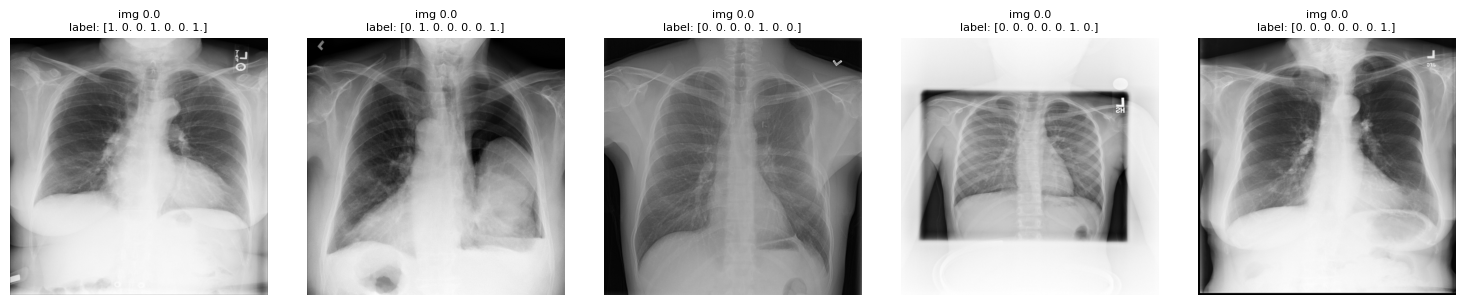

In [50]:
def show_first_images(ds, n=5):
    """
    Display the first *n* images contained in `image_input`
    of a `tf.data.Dataset` whose elements look like
        ({"image_input": <tensor>, ...}, label)   # or
        {"image_input": <tensor>, ...}            # if unlabeled
    """
    plt.figure(figsize=(3 * n, 3))

    for i, sample in enumerate(ds.unbatch().take(n)):
        # Handle both (inputs, label) and inputs‑only cases
        if isinstance(sample, tuple):
            inputs, label = sample
        else:
            inputs, label = sample, None

        img = inputs["image_input"]            # (H, W, C) float or uint8
        debug = inputs["input_debug"]

        # Tensor → NumPy for matplotlib
        img_np = img.numpy()

        # Squeeze the channel dim if it’s single‑channel
        if img_np.shape[-1] == 1:
            img_np = img_np.squeeze(-1)
            cmap = "gray"
        else:
            cmap = None                        # default = RGB

        plt.subplot(1, n, i + 1)
        plt.imshow(img_np, cmap=cmap)
        plt.axis("off")
        
        title = f"img {debug}"
        if label is not None:
            # label could be tensor → convert to Python scalar / list
            label_val = label.numpy()
            # Flatten to plain int/float if possible
            if label_val.size == 1:
                label_val = label_val.item()
            title += f"\nlabel: {label_val}"
        plt.title(title, fontsize=8)

    plt.tight_layout()
    plt.show()


show_first_images(train_ds)

In [51]:
# Save the history to a JSON file
def save_history(history, filename):
    with open(filename, 'w') as f:
        json.dump(history.history, f)

# Load the history from a JSON file
def load_history(filename):
    with open(filename, 'r') as f:
        history = json.load(f)
    return history

In [60]:
import math
EPOCHS=15
AUC_PATIENCE_FACTOR = 4
AUC_PATIENCE=math.ceil(EPOCHS/AUC_PATIENCE_FACTOR)
LR_PATIENCE=math.ceil(EPOCHS/10)
LR_PATIENCE=3
print(f"{EPOCHS=} {AUC_PATIENCE=} {LR_PATIENCE=}")

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        # monitor='val_auc',
        monitor='val_loss',
        patience=AUC_PATIENCE,
        # mode='max',
        restore_best_weights=True,
        # min_delta=1e-4,       # ignore <0.0001 change
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        # monitor='val_auc',
        monitor='val_loss',
        factor=0.5,
        patience=LR_PATIENCE,
        min_lr=1e-6
    )
]


model_w_history = []


num_tabular_features = 3
model = create_multitask_hybrid_model(num_tabular_features)

LOAD_FROM_FILE_DONT_TRAIN = False
model_path   = os.path.join(DRIVE_PATH, f'model_multitask.keras')
history_path = os.path.join(DRIVE_PATH, f'model_multitask_history.json')

if LOAD_FROM_FILE_DONT_TRAIN:
    model = tf.keras.models.load_model(model_path)
    history = load_history(history_path)
    print(f"Multitask Model LOADED from file {model_path} and {history_path}")
else:
    history = model.fit(
        train_ds, 
        epochs=EPOCHS, 
        validation_data=val_ds, 
        callbacks=callbacks
    )
    print(f"Model multitask trained successfully")

    model.save(model_path)
    save_history(history, history_path)
    print(f"Saved to keras file {model_path} and {history_path}")

    model_w_history.append( (model, history) )

EPOCHS=15 AUC_PATIENCE=4 LR_PATIENCE=3
Epoch 1/15


2025-04-13 14:47:00.793081: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 7463 of 24399
2025-04-13 14:47:10.835358: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 13220 of 24399
2025-04-13 14:47:30.789551: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 24003 of 24399
2025-04-13 14:47:31.303338: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


3050/3050 ━━━━━━━━━━━━━━━━━━━━ 128s 21ms/step - accuracy: 0.1985 - auc: 0.5971 - bin_accuracy: 0.7707 - loss: 12.5176 - precision: 0.2309 - recall: 0.0932 - val_accuracy: 0.2682 - val_auc: 0.7127 - val_bin_accuracy: 0.8156 - val_loss: 11.5104 - val_precision: 0.4808 - val_recall: 0.0415 - learning_rate: 1.0000e-04
Epoch 2/15


2025-04-13 14:49:00.584552: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 7092 of 24399
2025-04-13 14:49:10.586842: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 13014 of 24399
2025-04-13 14:49:20.597828: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 17921 of 24399
2025-04-13 14:49:30.706811: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 23156 of 24399


   9/3050 ━━━━━━━━━━━━━━━━━━━━ 48s 16ms/step - accuracy: 0.2628 - auc: 0.7160 - bin_accuracy: 0.7926 - loss: 10.8389 - precision: 0.1611 - recall: 0.0093        

2025-04-13 14:49:32.396894: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


3050/3050 ━━━━━━━━━━━━━━━━━━━━ 89s 15ms/step - accuracy: 0.2622 - auc: 0.7081 - bin_accuracy: 0.8130 - loss: 11.2637 - precision: 0.4388 - recall: 0.0202 - val_accuracy: 0.2764 - val_auc: 0.7222 - val_bin_accuracy: 0.8158 - val_loss: 10.6550 - val_precision: 0.4731 - val_recall: 0.0201 - learning_rate: 1.0000e-04
Epoch 3/15


2025-04-13 14:50:30.384654: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 7679 of 24399
2025-04-13 14:50:40.386485: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 14017 of 24399
2025-04-13 14:50:50.387748: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 19205 of 24399


   9/3050 ━━━━━━━━━━━━━━━━━━━━ 45s 15ms/step - accuracy: 0.3452 - auc: 0.7048 - bin_accuracy: 0.7899 - loss: 9.7506 - precision: 0.4188 - recall: 0.0347

2025-04-13 14:50:59.942687: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


3050/3050 ━━━━━━━━━━━━━━━━━━━━ 87s 15ms/step - accuracy: 0.2740 - auc: 0.7202 - bin_accuracy: 0.8132 - loss: 10.5464 - precision: 0.4630 - recall: 0.0250 - val_accuracy: 0.2843 - val_auc: 0.6993 - val_bin_accuracy: 0.7879 - val_loss: 12.1795 - val_precision: 0.3242 - val_recall: 0.1425 - learning_rate: 1.0000e-04
Epoch 4/15


2025-04-13 14:51:57.985742: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 7583 of 24399
2025-04-13 14:52:07.988418: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 13542 of 24399


   9/3050 ━━━━━━━━━━━━━━━━━━━━ 46s 15ms/step - accuracy: 0.2203 - auc: 0.7374 - bin_accuracy: 0.7843 - loss: 10.7721 - precision: 0.2222 - recall: 0.0037        

2025-04-13 14:52:27.614911: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


3050/3050 ━━━━━━━━━━━━━━━━━━━━ 88s 15ms/step - accuracy: 0.2820 - auc: 0.7306 - bin_accuracy: 0.8148 - loss: 10.0899 - precision: 0.4800 - recall: 0.0263 - val_accuracy: 0.2895 - val_auc: 0.7411 - val_bin_accuracy: 0.8178 - val_loss: 9.8788 - val_precision: 0.5755 - val_recall: 0.0311 - learning_rate: 1.0000e-04
Epoch 5/15


2025-04-13 14:53:25.093147: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 7740 of 24399
2025-04-13 14:53:35.096956: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 13629 of 24399


   1/3050 ━━━━━━━━━━━━━━━━━━━━ 34:52:26 41s/step - accuracy: 0.1250 - auc: 0.7707 - bin_accuracy: 0.8571 - loss: 10.7546 - precision: 1.0000 - recall: 0.1111

2025-04-13 14:53:55.085297: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 24209 of 24399
2025-04-13 14:53:55.224791: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


3050/3050 ━━━━━━━━━━━━━━━━━━━━ 88s 15ms/step - accuracy: 0.2819 - auc: 0.7340 - bin_accuracy: 0.8148 - loss: 9.9118 - precision: 0.4779 - recall: 0.0288 - val_accuracy: 0.2964 - val_auc: 0.7440 - val_bin_accuracy: 0.8163 - val_loss: 9.7728 - val_precision: 0.5020 - val_recall: 0.0650 - learning_rate: 1.0000e-04
Epoch 6/15


2025-04-13 14:54:53.184566: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 7534 of 24399
2025-04-13 14:55:03.186585: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 13481 of 24399
2025-04-13 14:55:23.192737: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 23972 of 24399


   8/3050 ━━━━━━━━━━━━━━━━━━━━ 49s 16ms/step - accuracy: 0.3042 - auc: 0.7910 - bin_accuracy: 0.8027 - loss: 8.2545 - precision: 0.6955 - recall: 0.0543

2025-04-13 14:55:23.827476: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


3050/3050 ━━━━━━━━━━━━━━━━━━━━ 88s 15ms/step - accuracy: 0.2928 - auc: 0.7434 - bin_accuracy: 0.8151 - loss: 9.6885 - precision: 0.4895 - recall: 0.0417 - val_accuracy: 0.2751 - val_auc: 0.7458 - val_bin_accuracy: 0.8151 - val_loss: 9.6007 - val_precision: 0.4749 - val_recall: 0.0579 - learning_rate: 1.0000e-04
Epoch 7/15


2025-04-13 14:56:20.684742: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 7856 of 24399
2025-04-13 14:56:30.707272: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 13673 of 24399


   1/3050 ━━━━━━━━━━━━━━━━━━━━ 34:45:31 41s/step - accuracy: 0.0000e+00 - auc: 0.6064 - bin_accuracy: 0.8214 - loss: 9.9250 - precision: 0.0000e+00 - recall: 0.0000e+00

2025-04-13 14:56:50.688646: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 24230 of 24399
2025-04-13 14:56:50.800418: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


3050/3050 ━━━━━━━━━━━━━━━━━━━━ 88s 15ms/step - accuracy: 0.2935 - auc: 0.7477 - bin_accuracy: 0.8151 - loss: 9.4253 - precision: 0.5041 - recall: 0.0483 - val_accuracy: 0.2964 - val_auc: 0.7514 - val_bin_accuracy: 0.8141 - val_loss: 9.4779 - val_precision: 0.4677 - val_recall: 0.0831 - learning_rate: 1.0000e-04
Epoch 8/15


2025-04-13 14:57:48.784479: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 7356 of 24399
2025-04-13 14:58:08.726544: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 19680 of 24399


   8/3050 ━━━━━━━━━━━━━━━━━━━━ 47s 16ms/step - accuracy: 0.2549 - auc: 0.7278 - bin_accuracy: 0.8304 - loss: 12.4788 - precision: 0.5549 - recall: 0.0653

2025-04-13 14:58:17.629849: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


3050/3050 ━━━━━━━━━━━━━━━━━━━━ 86s 15ms/step - accuracy: 0.3035 - auc: 0.7511 - bin_accuracy: 0.8161 - loss: 9.4224 - precision: 0.5186 - recall: 0.0532 - val_accuracy: 0.3052 - val_auc: 0.7526 - val_bin_accuracy: 0.8158 - val_loss: 9.3983 - val_precision: 0.4932 - val_recall: 0.0923 - learning_rate: 1.0000e-04
Epoch 9/15


2025-04-13 14:59:14.489228: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 9008 of 24399
2025-04-13 14:59:24.504003: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 15706 of 24399


   9/3050 ━━━━━━━━━━━━━━━━━━━━ 44s 15ms/step - accuracy: 0.3246 - auc: 0.7749 - bin_accuracy: 0.8091 - loss: 8.0042 - precision: 0.4411 - recall: 0.0820

2025-04-13 14:59:40.826269: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


3050/3050 ━━━━━━━━━━━━━━━━━━━━ 83s 15ms/step - accuracy: 0.3054 - auc: 0.7545 - bin_accuracy: 0.8162 - loss: 9.2416 - precision: 0.5148 - recall: 0.0563 - val_accuracy: 0.2977 - val_auc: 0.7430 - val_bin_accuracy: 0.8112 - val_loss: 9.6403 - val_precision: 0.4563 - val_recall: 0.1422 - learning_rate: 1.0000e-04
Epoch 10/15


2025-04-13 15:00:38.400384: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 8238 of 24399
2025-04-13 15:00:48.417922: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 14579 of 24399


   8/3050 ━━━━━━━━━━━━━━━━━━━━ 49s 16ms/step - accuracy: 0.3193 - auc: 0.8223 - bin_accuracy: 0.8373 - loss: 10.0872 - precision: 0.6112 - recall: 0.1110

2025-04-13 15:01:04.495332: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


3050/3050 ━━━━━━━━━━━━━━━━━━━━ 84s 15ms/step - accuracy: 0.3102 - auc: 0.7590 - bin_accuracy: 0.8156 - loss: 9.2660 - precision: 0.5107 - recall: 0.0632 - val_accuracy: 0.3108 - val_auc: 0.7623 - val_bin_accuracy: 0.8152 - val_loss: 9.1444 - val_precision: 0.4842 - val_recall: 0.0900 - learning_rate: 1.0000e-04
Epoch 11/15


2025-04-13 15:02:01.396025: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 7597 of 24399
2025-04-13 15:02:11.405573: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 13255 of 24399


   8/3050 ━━━━━━━━━━━━━━━━━━━━ 49s 16ms/step - accuracy: 0.2366 - auc: 0.7423 - bin_accuracy: 0.7998 - loss: 7.5693 - precision: 0.4571 - recall: 0.0407

2025-04-13 15:02:30.918025: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


3050/3050 ━━━━━━━━━━━━━━━━━━━━ 86s 15ms/step - accuracy: 0.3024 - auc: 0.7596 - bin_accuracy: 0.8149 - loss: 9.0838 - precision: 0.5171 - recall: 0.0676 - val_accuracy: 0.2889 - val_auc: 0.7468 - val_bin_accuracy: 0.8128 - val_loss: 9.5255 - val_precision: 0.4524 - val_recall: 0.0885 - learning_rate: 1.0000e-04
Epoch 12/15


2025-04-13 15:03:28.286283: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 7551 of 24399
2025-04-13 15:03:38.286770: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 13921 of 24399


   9/3050 ━━━━━━━━━━━━━━━━━━━━ 46s 15ms/step - accuracy: 0.3155 - auc: 0.8220 - bin_accuracy: 0.7892 - loss: 8.0728 - precision: 0.4143 - recall: 0.0273

2025-04-13 15:03:57.040907: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


3050/3050 ━━━━━━━━━━━━━━━━━━━━ 86s 15ms/step - accuracy: 0.3001 - auc: 0.7597 - bin_accuracy: 0.8147 - loss: 9.0353 - precision: 0.5042 - recall: 0.0661 - val_accuracy: 0.3357 - val_auc: 0.7617 - val_bin_accuracy: 0.8156 - val_loss: 9.1496 - val_precision: 0.4923 - val_recall: 0.1226 - learning_rate: 1.0000e-04
Epoch 13/15


2025-04-13 15:04:54.185700: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 7675 of 24399
2025-04-13 15:05:04.194961: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 13693 of 24399
2025-04-13 15:05:24.317822: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 24023 of 24399


   8/3050 ━━━━━━━━━━━━━━━━━━━━ 48s 16ms/step - accuracy: 0.3729 - auc: 0.7619 - bin_accuracy: 0.8076 - loss: 8.6180 - precision: 0.1644 - recall: 0.0187        

2025-04-13 15:05:24.912418: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


3050/3050 ━━━━━━━━━━━━━━━━━━━━ 88s 15ms/step - accuracy: 0.3152 - auc: 0.7634 - bin_accuracy: 0.8153 - loss: 9.1142 - precision: 0.5229 - recall: 0.0737 - val_accuracy: 0.2951 - val_auc: 0.7430 - val_bin_accuracy: 0.8096 - val_loss: 9.7857 - val_precision: 0.4298 - val_recall: 0.1109 - learning_rate: 1.0000e-04
Epoch 14/15


2025-04-13 15:06:22.691245: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 7566 of 24399
2025-04-13 15:06:42.702266: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 19810 of 24399


   7/3050 ━━━━━━━━━━━━━━━━━━━━ 52s 17ms/step - accuracy: 0.3925 - auc: 0.7831 - bin_accuracy: 0.7962 - loss: 8.8752 - precision: 0.4877 - recall: 0.0598

2025-04-13 15:06:50.993711: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


3050/3050 ━━━━━━━━━━━━━━━━━━━━ 86s 15ms/step - accuracy: 0.3147 - auc: 0.7654 - bin_accuracy: 0.8146 - loss: 8.9884 - precision: 0.4998 - recall: 0.0741 - val_accuracy: 0.3341 - val_auc: 0.7675 - val_bin_accuracy: 0.8159 - val_loss: 9.0146 - val_precision: 0.4967 - val_recall: 0.1351 - learning_rate: 5.0000e-05
Epoch 15/15


2025-04-13 15:07:47.997310: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 7871 of 24399
2025-04-13 15:08:07.912130: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 18775 of 24399


   8/3050 ━━━━━━━━━━━━━━━━━━━━ 48s 16ms/step - accuracy: 0.2020 - auc: 0.7076 - bin_accuracy: 0.7961 - loss: 8.3315 - precision: 0.6318 - recall: 0.0981

2025-04-13 15:08:17.937975: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


3050/3050 ━━━━━━━━━━━━━━━━━━━━ 87s 15ms/step - accuracy: 0.3188 - auc: 0.7642 - bin_accuracy: 0.8162 - loss: 8.9818 - precision: 0.5220 - recall: 0.0786 - val_accuracy: 0.3266 - val_auc: 0.7715 - val_bin_accuracy: 0.8155 - val_loss: 8.9492 - val_precision: 0.4926 - val_recall: 0.1351 - learning_rate: 5.0000e-05
Model multitask trained successfully
Saved to keras file /workspace/chest/drive/MyDrive/AAI-590_Collabs/model_multitask.keras and /workspace/chest/drive/MyDrive/AAI-590_Collabs/model_multitask_history.json


## Model Evaluation

In [ ]:
# tf.keras.backend.clear_session() # Destroys the current TF graph and creates a new one

382/382 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.3259 - auc: 0.7694 - bin_accuracy: 0.8169 - loss: 8.8662 - precision: 0.4979 - recall: 0.1314


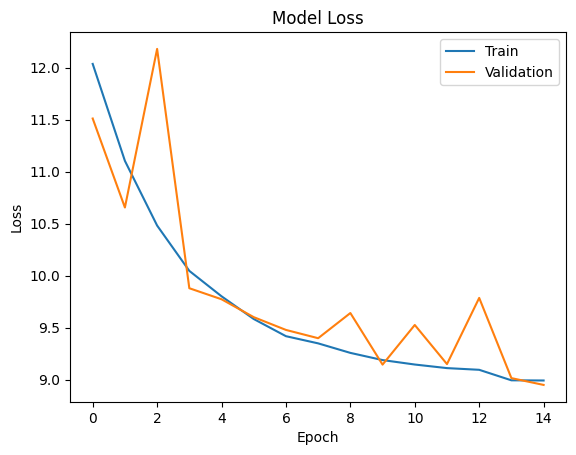

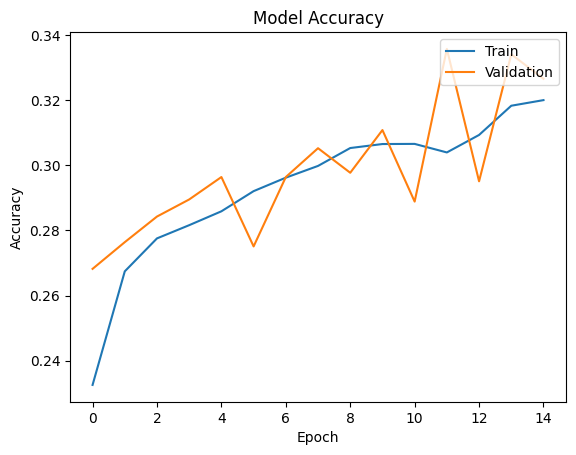

  AUC (ROC):        0.7715
  Accuracy:         0.3266
  Binary Accuracy:  0.8155
  Precision:        0.4926
  Recall:           0.1351
  Loss:             8.9492
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1

2025-04-13 15:34:00.159442: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

In [65]:
# import classification_report
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score

for i, m_h in enumerate(model_w_history):
    model, history = m_h
    # Get validation data for the current model
    ds_train, ds_val, ds_test = (train_ds, val_ds, test_ds)

    # Make predictions on the validation set
    results = model.evaluate(ds_val, verbose=1, return_dict=True)

    # plot loss and accuracy
    # history = model.history
    plt.plot(history.history['loss']) # Access the loss from the history object
    plt.plot(history.history['val_loss'])

    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

    # Check if 'accuracy' is in the history keys before plotting
    if 'accuracy' in history.history:
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])

        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper right')
        plt.show()
    else:
        print("Accuracy not found in history. Skipping accuracy plot.")

    # Evaluate the model
    print(f"  AUC (ROC):        {results.get('auc', 'N/A'):.4f}")
    print(f"  Accuracy:         {results.get('accuracy', 'N/A'):.4f}")
    print(f"  Binary Accuracy:  {results.get('bin_accuracy', 'N/A'):.4f}")
    print(f"  Precision:        {results.get('precision', 'N/A'):.4f}")
    print(f"  Recall:           {results.get('recall', 'N/A'):.4f}")
    print(f"  Loss:             {results.get('loss', 'N/A'):.4f}")
    # y_pred = (predictions > 0.5).astype(int)
    # accuracy = accuracy_score(y_val, y_pred)
    # precision = precision_score(y_val, y_pred)
    # recall = recall_score(y_val, y_pred)
    # print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}")
    # print(classification_report(y_val, y_pred))

    # Prepare for classification_report
    y_true = []
    y_pred = []

    # Iterate through the validation dataset to get true labels and predictions
    for x_batch, y_batch in ds_val:
        # Get true labels
        y_true.extend(y_batch.numpy())

        # Make predictions
        predictions = model.predict(x_batch)

        # Determine predicted labels based on the model's output
        if predictions.shape[-1] > 1:  # Multi-class classification
            predicted_labels = np.argmax(predictions, axis=-1)
        else:  # Binary classification (assuming sigmoid activation)
            predicted_labels = (predictions > 0.5).astype(int).flatten()
        y_pred.extend(predicted_labels)

    # Generate and print the classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))


In [93]:
def make_predictions(image_path, tabular_data, resized_images_path, model_w_history):
    # Preprocess the image and tabular data
    image_data = np.expand_dims(preprocess_image(os.path.join(resized_images_path, os.path.basename(image_path))), axis=0)
    tabular_data = np.expand_dims(tabular_data, axis=0)
    inputs = (image_data, tabular_data)
    if isinstance(inputs, tuple):
        inputs = {"image_input": inputs[0], "tabular_input": inputs[1]}

    batch_size = inputs["image_input"].shape[0]
    
    # Initialize a dictionary to store individual task predictions
    predictions = []

    model, history = model_w_history[0]
    pred = model.predict(inputs)

    return pred[0].astype(float)

### Test with Test data

In [73]:
print(model_w_history)

[(<Functional name=functional_5, built=True>, <keras.src.callbacks.history.History object at 0x7269aa88fe10>)]


In [94]:
# Select a few rows from the test dataset
num_rows_to_pick = 100 # Adjust the number of rows as needed
rows_to_predict = test_df.sample(n=num_rows_to_pick, random_state=42)
display(rows_to_predict.head())

,Image Index,Follow-up #,Patient Age,Patient Gender,encoded_labels,has_Infection/Infiltration,has_Fluid Related Issues,has_Lung Structure Issues,has_Nodule/Mass,has_Cardiac Issues,has_Hernia,has_No Finding
4457,00013549_002.png,-0.362342,0.587909,0,"[0, 0, 0, 0, 0, 0, 1]",0,0,0,1,0,0,0
5605,00019087_017.png,1.065656,-0.964004,1,"[0, 1, 0, 0, 0, 0, 0]",0,1,0,0,0,0,0
4686,00014647_010.png,0.399257,-0.343239,1,"[0, 0, 0, 0, 1, 0, 0]",0,0,1,0,0,0,0
1055,00010047_000.png,-0.552742,-0.653622,0,"[0, 0, 0, 0, 0, 1, 0]",0,0,0,0,0,0,1
4813,00015163_001.png,-0.457542,1.705287,1,"[0, 0, 0, 0, 0, 0, 1]",0,0,0,1,0,0,0


In [95]:
# Prepare the image paths and tabular data for prediction
image_paths = rows_to_predict['Image Index'].values
tabular_data = rows_to_predict[['Follow-up #', 'Patient Age', 'Patient Gender']].values
# Assuming 'RESIZED_IMAGES_PATH' is defined correctly
resized_images_path = RESIZED_IMAGES_PATH

# Predict labels for each picked image
predictions_results = []
for image_path, tabular_row in zip(image_paths, tabular_data):
    predictions = make_predictions(image_path, tabular_row, resized_images_path, model_w_history)
    predictions_results.append(predictions)

rows_to_predict['predicted_group_labels'] = predictions_results

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━

In [96]:
display(rows_to_predict)

,Image Index,Follow-up #,Patient Age,Patient Gender,encoded_labels,has_Infection/Infiltration,has_Fluid Related Issues,has_Lung Structure Issues,has_Nodule/Mass,has_Cardiac Issues,has_Hernia,has_No Finding,predicted_group_labels
4457,00013549_002.png,-0.362342,0.587909,0,"[0, 0, 0, 0, 0, 0, 1]",0,0,0,1,0,0,0,"[0.0482693649828434, 0.10968942940235138, 0.00..."
5605,00019087_017.png,1.065656,-0.964004,1,"[0, 1, 0, 0, 0, 0, 0]",0,1,0,0,0,0,0,"[0.03526781126856804, 0.32179850339889526, 0.0..."
4686,00014647_010.png,0.399257,-0.343239,1,"[0, 0, 0, 0, 1, 0, 0]",0,0,1,0,0,0,0,"[0.03739507496356964, 0.3542996644973755, 0.00..."
1055,00010047_000.png,-0.552742,-0.653622,0,"[0, 0, 0, 0, 0, 1, 0]",0,0,0,0,0,0,1,"[0.043933793902397156, 0.08584032207727432, 0...."
4813,00015163_001.png,-0.457542,1.705287,1,"[0, 0, 0, 0, 0, 0, 1]",0,0,0,1,0,0,0,"[0.037347592413425446, 0.24761389195919037, 0...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5187,00017116_000.png,-0.552742,-0.343239,0,"[0, 1, 0, 0, 0, 0, 0]",0,1,0,0,0,0,0,"[0.04589802771806717, 0.16170601546764374, 0.0..."
5715,00019593_006.png,0.018457,0.277527,0,"[0, 0, 0, 1, 0, 0, 0]",1,0,0,0,0,0,0,"[0.04674829542636871, 0.42742738127708435, 0.0..."
3859,00010459_002.png,-0.362342,0.215450,0,"[0, 0, 0, 1, 0, 0, 0]",1,0,0,0,0,0,0,"[0.052383117377758026, 0.1993674337863922, 0.0..."
6345,00022274_000.png,-0.552742,0.091297,0,"[0, 0, 0, 1, 0, 0, 0]",1,0,0,0,0,0,0,"[0.04991351440548897, 0.11709175258874893, 0.0..."


In [97]:
from sklearn.metrics import classification_report, accuracy_score

# Assumes categories = ['Cardiac Issues', 'Fluid Related Issues', ..., 'Nodule/Mass']
print("\nClassification Report:\n")
print(f"{'Category':30} {'Precision':>9} {'Recall':>9} {'F1-score':>9} {'Support':>9} {'Accuracy':>9}")

# Extract actual and predicted group labels
true_group_labels = list(rows_to_predict['encoded_labels'])
pred_group_labels = list(rows_to_predict['predicted_group_labels'])

# Loop over each category
for i, category in enumerate(all_labels):
    y_true = [row[i] for row in true_group_labels]
    y_pred = [1 if row[i] >= 0.5 else 0 for row in pred_group_labels]  # Apply threshold

    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    acc = accuracy_score(y_true, y_pred)

    precision = report.get('1', {}).get('precision', 0.0)
    recall    = report.get('1', {}).get('recall', 0.0)
    f1        = report.get('1', {}).get('f1-score', 0.0)
    support   = int(report.get('1', {}).get('support', 0))

    print(f"{category:30} {precision:9.2f} {recall:9.2f} {f1:9.2f} {support:9d} {acc:9.2f}")



Classification Report:

Category                       Precision    Recall  F1-score   Support  Accuracy
Cardiac Issues                      0.00      0.00      0.00         4      0.96
Fluid Related Issues                0.67      0.32      0.43        19      0.84
Hernia                              0.00      0.00      0.00         1      0.99
Infection/Infiltration              0.00      0.00      0.00        24      0.76
Lung Structure Issues               0.27      0.14      0.19        21      0.74
No Finding                          0.38      0.12      0.18        25      0.73
Nodule/Mass                         0.00      0.00      0.00        23      0.77
